<img src="../../images/qiskit-heading.gif" alt="Note: In order for images to show up in this jupyter notebook you need to select File => Trusted Notebook" width="500 px" align="left">

## _*The Deutsch-Jozsa Algorithm*_ 

The [Deutsch-Jozsa algorithm](http://rspa.royalsocietypublishing.org/content/439/1907/553) is one of the earliest examples demonstrating the power of quantum computers. The algorithm deals with guessing the type of a hidden Boolean function given as an oracle. The Boolean function is promised to be either balanced, i.e., whose values are $0$ on half of its inputs, or constant, i.e., whose values are the same on all inputs. 

Classically, in the best case, two queries to the oracle can determine if the hidden Boolean function is balanced; in the worst case, at least half of the inputs must be queried to determine if the hidden Boolean function is constant for all inputs. On the other hand, the Deutsch-Jozsa algorithm can determine the Boolean function with one quantum query.   

The latest version of this notebook is available on https://github.com/qiskit/qiskit-tutorial.

***
### Contributors
Rudy Raymond

## Introduction <a id='introduction'></a>

The algorithm in this notebook follows that in [Cleve et al. 1997](https://arxiv.org/pdf/quant-ph/9708016.pdf). We assume that the input to the oracle $f$ is a $n$-bit string. Namely, for each $x\ in \{0,1\}^n$, the value of $f(x)$ is promised to be either constant, i.e., the same for all $x$, or balanced, i.e., exactly half of the $n$-bit string whose $f(x) = 0$. 

## The Algorithm

The algorithm is quite simple as follows.
1. Prepare two quantum registers initialized to zero. The first is an $n$-qubit reqister for querying the oracle, and the second is a one-qubit register for storing the answer of the oracle
$$
|0\ldots 0\rangle |0\rangle
$$
2. Create the superposition of all input queries in the first register by applying the Hadamard gate to each qubit.
$$
H^{\otimes^n} |0\ldots 0\rangle |0\rangle = \frac{1}{\sqrt{2^n}}\sum_{i=0}^{2^n-1}|i\rangle |0\rangle 
$$
3. Flip the second register and apply the Hadamard gate. This is to store the answer of the oracle in the phase.
$$
\frac{1}{\sqrt{2^n}}\sum_{i=0}^{2^n-1}|i\rangle |0\rangle \rightarrow \frac{1}{\sqrt{2^{n+1}}}\sum_{i=0}^{2^n-1}|i\rangle ( |0\rangle - |1\rangle )
$$
4. Query the oracle
$$
\frac{1}{\sqrt{2^{n+1}}}\sum_{i=0}^{2^n-1}|i\rangle ( |0\rangle - |1\rangle ) \rightarrow \frac{1}{\sqrt{2^{n+1}}}\sum_{i=0}^{2^n-1}(-1)^{f(i)}|i\rangle ( |0\rangle - |1\rangle ) 
$$
5. Apply the Hadamard gate to the first register

6. Measure the first register. If it is non-zero, then conclude that the hidden Boolean function is balanced. Otherwise, conclude that it is constant. 

The correctness of the conclusion of the last step can be explained as follows. 

When the hidden Boolean function is constant, the quantum states before and after querying the oracle are the same. The inverse of the Hadamard gate is the Hadamard gate itself. Thus, by Step 5, we essentially reverse Step 2 to obtain the initial quantum state of all-zero at the first register.  

When the hidden Boolean function is balanced, the quantum state after querying the oracle is orthogonal to the quantum state before querying the oracle. Thus, by Step 5, when reverting the operation, we must end up with a quantum state that is orthogonal to the initial quantum state of all-zero at the first register. This means we should never obtain the all-zero state. 

## The Circuit <a id="circuit"></a>

We now implement the Deutsch-Jozsa algorithm with Qiskit by first preparing the environment.

In [1]:
# useful additional packages 
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# importing Qiskit
from qiskit import Aer, IBMQ
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit import available_backends, execute, register, get_backend, compile
from qiskit.wrapper.jupyter import *

# import basic plot tools
from qiskit.tools.visualization import circuit_drawer, plot_histogram

In [2]:
# Load our saved IBMQ accounts
IBMQ.load_accounts()

We first set the length of the $n$-bit string. 

In [3]:
n = 13 # the length of the first register for querying the oracle 

We then use Qiskit to program the algorithm.

In [4]:
# Choose a type of oracle at random. With probability half it is constant, 
# and with the same probability it is balanced
oracleType, oracleValue = np.random.randint(2), np.random.randint(2)

if oracleType == 0:
    print("The oracle returns a constant value ", oracleValue)
else:
    print("The oracle returns a balanced function")
    a = np.random.randint(1,2**n) # this is a hidden parameter for balanced oracle. 

# Creating registers
# n qubits for querying the oracle and one qubit for storing the answer
qr = QuantumRegister(n+1) #all qubits are initialized to zero
# for recording the measurement on the first register
cr = ClassicalRegister(n)

circuitName = "DeutschJozsa"
djCircuit = QuantumCircuit(qr, cr)

# Create the superposition of all input queries in the first register by applying the Hadamard gate to each qubit.
for i in range(n):
    djCircuit.h(qr[i])

# Flip the second register and apply the Hadamard gate.
djCircuit.x(qr[n])
djCircuit.h(qr[n])
    
# Apply barrier to mark the beginning of the oracle
djCircuit.barrier()

if oracleType == 0:#If the oracleType is "0", the oracle returns oracleValue for all input. 
    if oracleValue == 1:
        djCircuit.x(qr[n])
    else:
        djCircuit.iden(qr[n])
else: # Otherwise, it returns the inner product of the input with a (non-zero bitstring) 
    for i in range(n):
        if (a & (1 << i)):
            djCircuit.cx(qr[i], qr[n])
        
# Apply barrier to mark the end of the oracle
djCircuit.barrier()

# Apply Hadamard gates after querying the oracle
for i in range(n):
    djCircuit.h(qr[i])
    
# Measurement
djCircuit.barrier()
for i in range(n):
    djCircuit.measure(qr[i], cr[i])

The oracle returns a balanced function


## Experiment with Simulators

We can run the above circuit on the simulator. 

First, we draw the circuit.

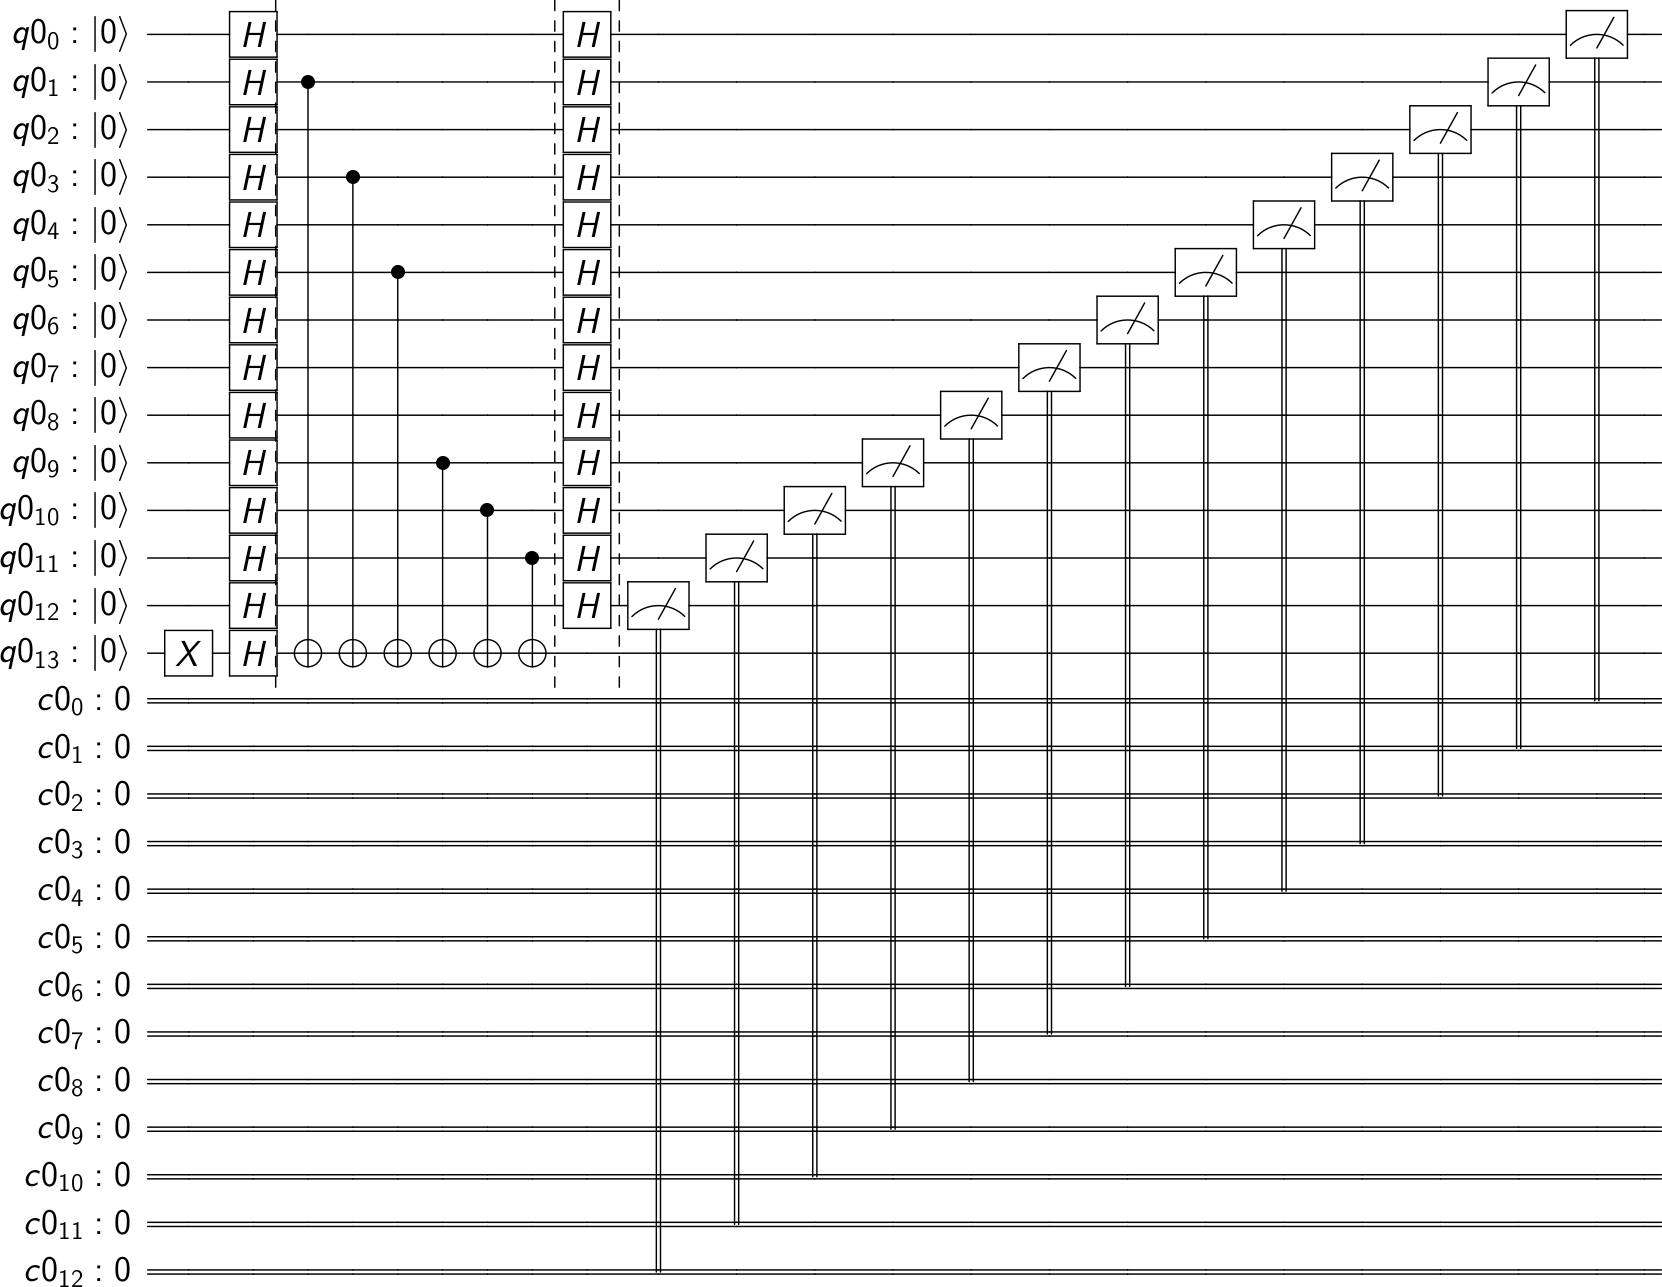

In [5]:
#draw the circuit
circuit_drawer(djCircuit)

We then run the circuit on the remote simulator.

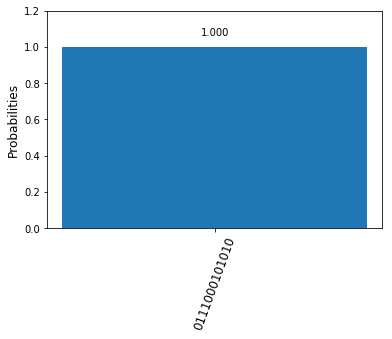

In [6]:
backend = Aer.get_backend('qasm_simulator')
shots = 1000
job = execute(djCircuit, backend=backend, shots=shots)
results = job.result() 
answer = results.get_counts()

plot_histogram(answer)

Repeating the above experiments, we can see that the result of the measurement is an all-zero bitstring if the oracle returns a constant value, or a non-zero bitstring otherwise.

## Experiment with Real Devices

We can run the circuit on the real device as below. However, notice that because the real devices are noisy, we cannot obtain the type of oracles with certainty, unlike when running the experiments with simulators. The Deutsch-Jozsa algorithm only shows the superiority of quantum computers against exact classical algorithms; when allowing some error, classically we can determine the type of the hidden Boolean function with a constant number of queries. This is asymptotically the same as the case with quantum computers. 

In [7]:
%%qiskit_job_status
backend = IBMQ.get_backend('ibmq_16_melbourne')
shots = 1000 
job = execute(djCircuit, backend=backend, shots=shots)

A Jupyter Widget

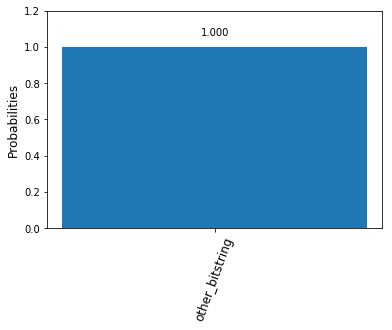

{'other_bitstring': 1000}


In [8]:
results = job.result()
answer = results.get_counts()

threshold = int(0.03 * shots) # the threshold of plotting significant measurements
filteredAnswer = {k: v for k,v in answer.items() if v >= threshold} # filter the answer for better view of plots

removedCounts = np.sum([ v for k,v in answer.items() if v < threshold ]) # number of counts removed 
filteredAnswer['other_bitstring'] = removedCounts  # the removed counts are assigned to a new index

plot_histogram(filteredAnswer)

print(filteredAnswer)